<a href="https://colab.research.google.com/github/danieljtrujillo/DataForecaster/blob/master/DataForecaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame


start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017, 1, 11)

df = web.DataReader("BAESY", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-05,29.250000,28.889999,28.90,29.250000,46200.0,26.641441
2017-01-06,29.820000,29.629999,29.82,29.639999,78300.0,26.996658
2017-01-09,29.180000,28.830000,28.85,29.040001,70500.0,26.450171
2017-01-10,29.870001,29.469999,29.48,29.719999,33100.0,27.069523
2017-01-11,29.879999,29.440001,29.59,29.799999,31700.0,27.142389


In [0]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

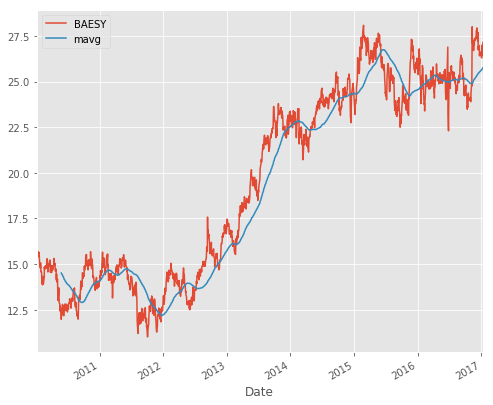

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='BAESY')
mavg.plot(label='mavg')
plt.legend()

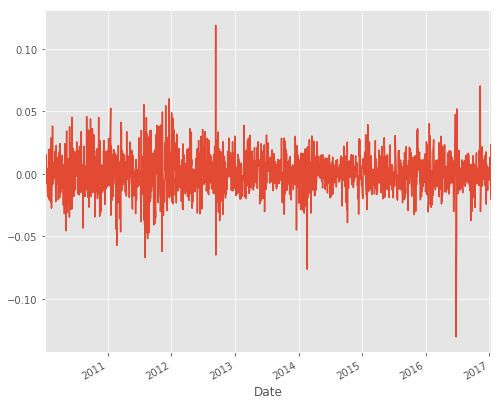

In [32]:
rets = close_px / close_px.shift(1) - 1 
rets.plot(label='return')